In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MABarbadillo/
%cd 'SPTProject/Rosetta'
import os

In [ ]:
##Install rosetta

!pip install rosetta-soil
from rosetta import rosetta, SoilData

In [3]:
import numpy as np
import pandas as pd
from scipy.io import loadmat

In [ ]:
####This calculates the daily hydraulic conductivity values using the Illston et al. (2008) and the Zhang et al. (2019) matric potential equations

##Daily delta reference temperatures at 60 cm depth for ACME site were taken from 'ACMEdeltaT.mat' file
##deltaT were then converted to matric potential values using two equations (i.e., Illston et al., 2008, and Zhang et.al., 2019)
##'MesoSoilv1_3.csv' file was loaded to  get the soil properties (%sand, silt, clay, bulk density, water contents at -33 and -1500 kPa) and K0 at 60 cm depth for ACME site
##Hydraulic parameters (thetas, thetar, alpha, n, Ks) were estimated using Rosetta verrsions 1 and 3
##Volumetric water contents were calculated for both matric potential equations and for both versions of Rosetta
##Effective saturation (Se) was calculated for both matric potential equations and for both versions of Rosetta
##Daily hydraulic conductivity (K) values were calculated for both matric potential equations and for both versions of Rosetta

##A comparison between the K values obtained using K0+Rosetta V1 parameters and K0+Rosetta V3 parameters was made for both matric potential equations


In [ ]:
### STEPS

# Loading the matlab file 'ACMEdeltaT.mat'
acme_data = loadmat('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/ACMEdeltaT.mat')
df = pd.DataFrame(acme_data['ACMEdeltaT'])
tr60_data = [float(df.iloc[i, 4]) for i in range(2, len(df))]   #Extracts the TR60 starting from row 3 in column 5 as a float (python starts counting at 0)
time = [float(df.iloc[i, 0]) for i in range(2, len(df))]

# Calculate the matric_potential using Illston et al. (2008) equation
c = 0.717    #kPa
a = 1.788    #1/degree Celcius
mp_60_Ill = [-c*np.exp(a*tr60_data[i]) for i in range(len(tr60_data))]   #kPa

# Calculate the matric_potential using Zhang et al. (2019) equation
mp_60_Zha = [-2083/(1+np.exp(-3.35*(tr60_data[i]-3.17))) for i in range(len(tr60_data))]    #kPa

# Read the 'MesoSoilv1_3.csv' file, skipping the first row
# Integers 2, 3, 4, 5, 6, and 7 specify the columns for %sand, silt, clay, bulk density (g/cm3), and volumetric water contents (cm3/cm3) at -33 and -1500 kPa, respectively
df1 = pd.read_csv('/content/drive/MyDrive/MABarbadillo/SPTProject/Rosetta/MesoSoilv1_3.csv', header=0, skiprows=1)
data = df1.iloc[5: , [2, 3, 4, 5, 6, 7]].values.tolist()   #integer 5 specifies that the data reading starts at the 6th row (data at 60 cm depth is at the 6th row)
K0 = float(df1.iloc[5, 13])
L = float(df1.iloc[5, 14])

# Call the function to get hydraulic parameters
mean_1, stdev_1, codes_1 = rosetta(1, SoilData.from_array(data))    #for Rosetta Ver.1
mean_3, stdev_3, codes_3 = rosetta(3, SoilData.from_array(data))    #for Rosetta Ver.3

# Extract the hydraulic parameter values from the array
# Rosetta Ver.1
theta_r1 = float(mean_1[0][0])    #everything is at the first row
theta_s1 = float(mean_1[0][1])
alpha1 = (10**float(mean_1[0][2]))*10.2   # [1/kPa]   1kPa = 10.2 cm of water
n1 = 10**float(mean_1[0][3])
m1 = 1 - (1 / n1)
Ks_1 = 10**float(mean_1[0][4])

# Rosetta Ver.3
theta_r3 = float(mean_3[0][0])
theta_s3 = float(mean_3[0][1])
alpha3 = (10**float(mean_1[0][2]))*10.2   # [1/kPa]   1kPa = 10.2 cm of water
n3 = 10**float(mean_3[0][3])
m3 = 1 - (1 / n3)
Ks_3 = 10**float(mean_3[0][4])


# Converting Illston et al. (2008) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Ill = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Ill[i])**n1)**-m1 for i in range(len(mp_60_Ill))]
# Rosetta Ver.3
vwc3_Ill = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Ill[i])**n3)**-m3 for i in range(len(mp_60_Ill))]

# Converting Zhang et al. (2019) matric potential to volumetric water content (vwc) [cm3/cm3]
# Rosetta Ver.1
vwc1_Zha = [theta_r1 + (theta_s1 - theta_r1) * (1 + (-alpha1 * mp_60_Zha[i])**n1)**-m1 for i in range(len(mp_60_Zha))]
# Rosetta Ver.3
vwc3_Zha = [theta_r3 + (theta_s3 - theta_r3) * (1 + (-alpha3 * mp_60_Zha[i])**n3)**-m3 for i in range(len(mp_60_Zha))]


# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Illston et al., 2008]
# Rosetta Ver.1
Se1_Ill = [(vwc1_Ill[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Ill))]
# Rosetta Ver.3
Se3_Ill = [(vwc3_Ill[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Ill))]

# Converting volumetric water content to effective saturation (Se) [cm3/cm3] [Zhang et al., 2019]
# Rosetta Ver.1
Se1_Zha = [(vwc1_Zha[i] - theta_r1)/(theta_s1 - theta_r1) for i in range(len(vwc1_Zha))]
# Rosetta Ver.3
Se3_Zha = [(vwc3_Zha[i] - theta_r3)/(theta_s3 - theta_r3) for i in range(len(vwc3_Zha))]


# Calculating unsaturated hydraulic conductivity [cm/day]
L1 = 0.5   #default value

K_Se1_Ill = [Ks_1 * Se1_Ill[i]**L1 * (1 - (1 - Se1_Ill[i]**(1/m1))**m1)**2 for i in range(len(Se1_Ill))]       #Ks + L=0.5 + Rosetta V1 parameters + Illston
K_Se3_Ill = [Ks_3 * Se3_Ill[i]**L1 * (1 - (1 - Se3_Ill[i]**(1/m3))**m3)**2 for i in range(len(Se3_Ill))]       #Ks + L=0.5 + Rosetta V3 parameters + Illston
K_K0_Se1_Ill = [(K0*Se1_Ill[i]**L) * (1 - (1-Se1_Ill[i]**(n1/(n1-1)))**m1)**2 for i in range(len(Se1_Ill))]    #K0 + L= -1.71 + Rosetta V1 parameters + Illston
K_Se1_Zha = [Ks_1 * Se1_Zha[i]**L1 * (1 - (1 - Se1_Zha[i]**(1/m1))**m1)**2 for i in range(len(Se1_Zha))]       #Ks + L=0.5 + Rosetta V1 parameters + Zhang
K_Se3_Zha = [Ks_3 * Se3_Zha[i]**L1 * (1 - (1 - Se3_Zha[i]**(1/m3))**m3)**2 for i in range(len(Se3_Zha))]       #Ks + L=0.5 + Rosetta V3 parameters + Zhang

In [ ]:
# Printing of results

print('K0:', K0)
print('theta_r1:', theta_r1)
print('theta_r3:', theta_r3)
print('theta_s1:', theta_s1)
print('theta_s3:', theta_s3)
print('alpha1:', alpha1)
print('alpha3:', alpha3)
print('n1:', n1)
print('n3:', n3)
print('m1:', m1)
print('m3:', m3)
print('Ks_1:', Ks_1)
print('Ks_3:', Ks_3)
"""
print("vwc1_Ill:", vwc1_Ill)
print("vwc3_Ill:", vwc3_Ill)
print("vwc1_Zha:", vwc1_Zha)
print("vwc3_Zha:", vwc3_Zha)
print("Se1_Ill:", Se1_Ill)
print("Se3_Ill:", Se3_Ill)
print("Se1_Zha:", Se1_Zha)
print("Se3_Zha:", Se3_Zha)
print("K_Se1_Ill:", K_Se1_Ill)
print("K_Se3_Ill:", K_Se3_Ill)
print("K_K0_Se1_Ill:", K_K0_Se1_Ill)
print("K_K0_Se3_Ill:", K_K0_Se3_Ill)
print("K_Se1_Zha:", K_Se1_Zha)
print("K_Se3_Zha:", K_Se3_Zha)
print("K_K0_Se1_Zha:", K_K0_Se1_Zha)
print("K_K0_Se3_Zha:", K_K0_Se3_Zha)
"""

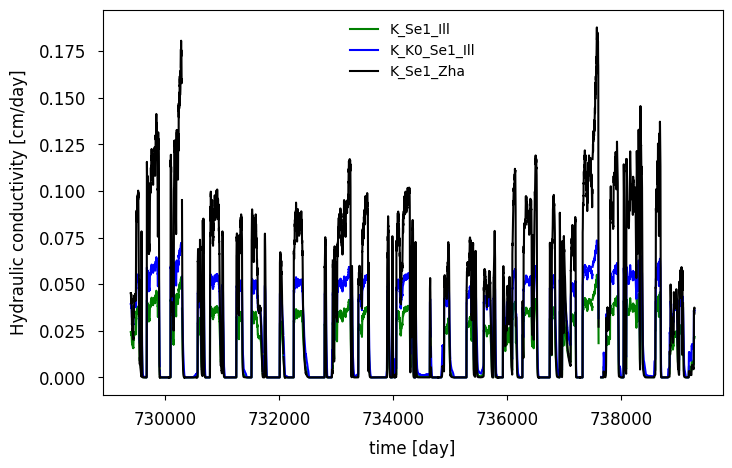

In [6]:
# Plotting of Results

import matplotlib.pyplot as plt


# Hydraulic conductivity values using Rosetta Version 1 parameters

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, K_Se1_Ill, color='green', markersize=0.05)
plt.plot(time, K_K0_Se1_Ill, color='blue', markersize=0.05)
plt.plot(time, K_Se1_Zha, color='black', markersize=0.05)

plt.legend(['K_Se1_Ill', 'K_K0_Se1_Ill', 'K_Se1_Zha'], fontsize=10, frameon=False)

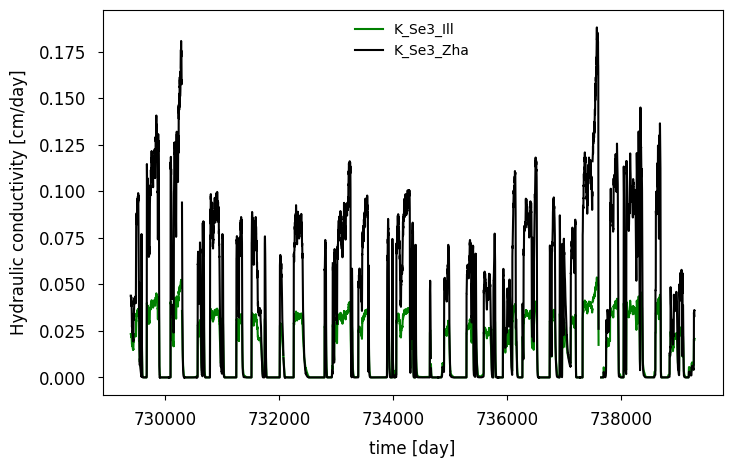

In [ ]:
# Hydraulic conductivity values using Rosetta Version 3 parameters

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, K_Se3_Ill, color='green', markersize=0.05)
plt.plot(time, K_Se3_Zha, color='black', markersize=0.05)

plt.legend(['K_Se3_Ill', 'K_Se3_Zha'], fontsize=10, frameon=False)

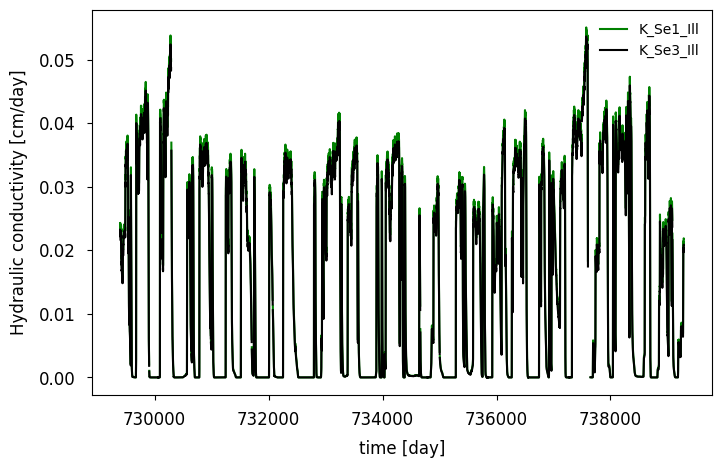

In [ ]:
# Hydraulic conductivity values using Rosetta Versions 1 and 3 parameters (Illston et al. (2008) MP equation

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, K_Se1_Ill, color='green', markersize=0.05)
plt.plot(time, K_Se3_Ill, color='black', markersize=0.05)

plt.legend(['K_Se1_Ill','K_Se3_Ill'], fontsize=10, frameon=False)

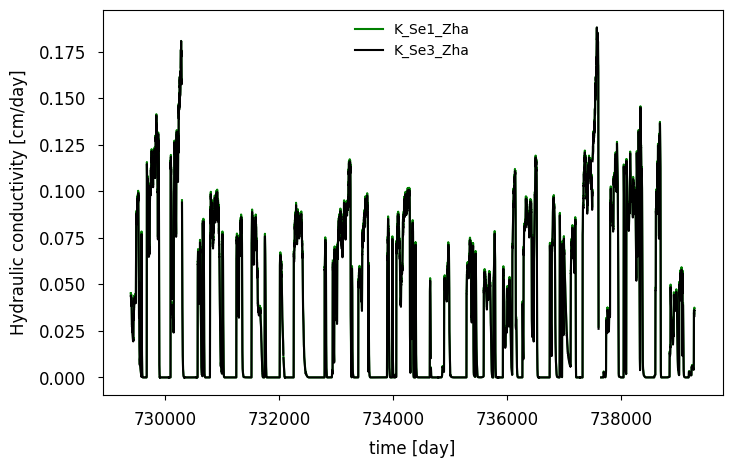

In [ ]:
# Hydraulic conductivity values using Rosetta Versions 1 and 3 parameters (Zhang et al. (2019) MP equation

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, K_Se1_Zha, color='green', markersize=0.05)
plt.plot(time, K_Se3_Zha, color='black', markersize=0.05)

plt.legend(['K_Se1_Zha','K_Se3_Zha'], fontsize=10, frameon=False)

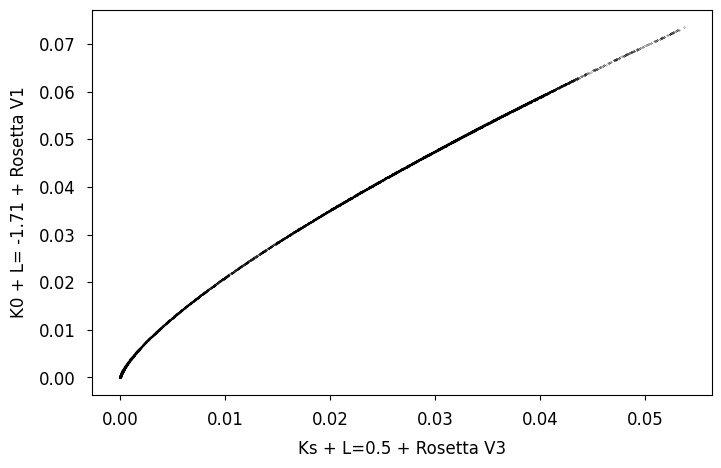

In [ ]:
# Hydraulic conductivity values for K0 + L= -1.71 + Rosetta V1 parameters and Ks + L=0.5 + Rosetta V3 parameters

fig = plt.figure(figsize=(8,5))
plt.xlabel('Ks + L=0.5 + Rosetta V3', fontsize=12, labelpad=8)
plt.ylabel('K0 + L= -1.71 + Rosetta V1', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(K_Se3_Ill, K_K0_Se1_Ill, 'ok', markersize=0.2)

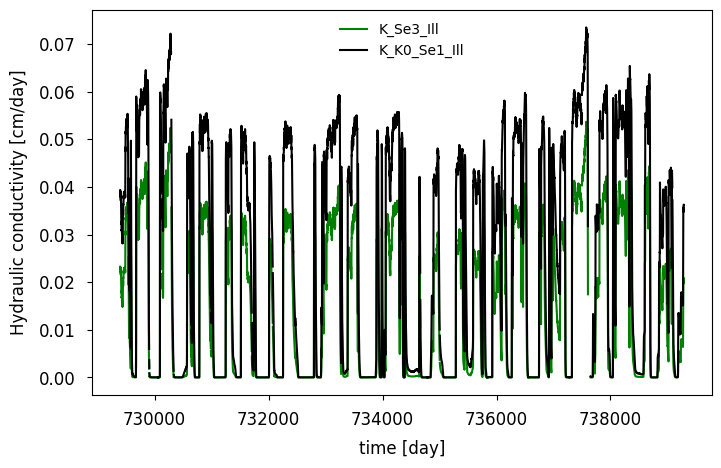

In [ ]:
# Hydraulic conductivity values for K0 + L= -1.71 + Rosetta V1 parameters and Ks + L=0.5 + Rosetta V3 parameters

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Hydraulic conductivity [cm/day]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, K_Se3_Ill, color='green', markersize=0.05)
plt.plot(time, K_K0_Se1_Ill, color='black', markersize=0.05)

plt.legend(['K_Se3_Ill','K_K0_Se1_Ill'], fontsize=10, frameon=False)

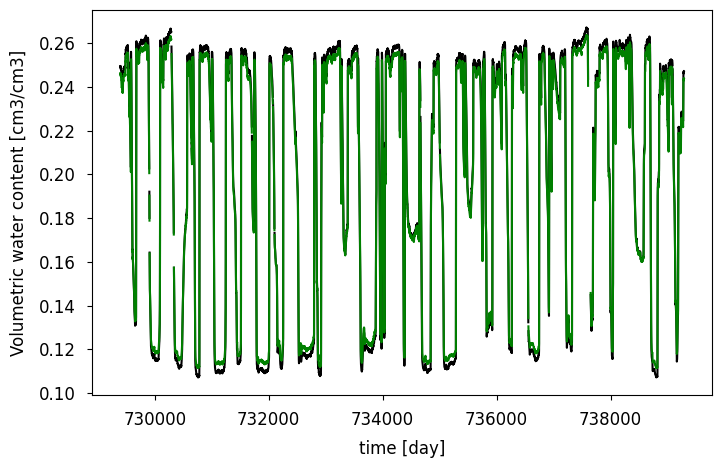

In [8]:
# Volumetric water content using Rosetta_V1 and V2 for Illston et al. (2008) MP equation

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Volumetric water content [cm3/cm3]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, vwc1_Ill, color='black', markersize=0.05)
plt.plot(time, vwc3_Ill, color='green', markersize=0.05)

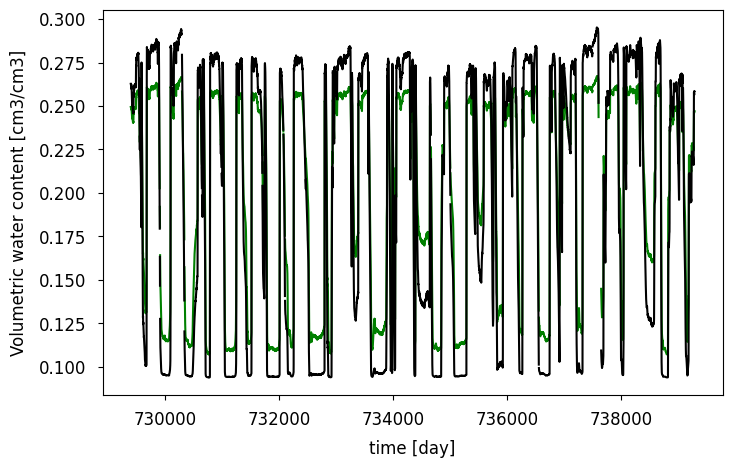

In [ ]:
# Volumetric water content using Rosetta_V1 for Illston et al. (2008) and Zhang et al. (2019) MP equations

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Volumetric water content [cm3/cm3]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, vwc1_Ill, color='green', markersize=0.05)
plt.plot(time, vwc1_Zha, color='black', markersize=0.05)

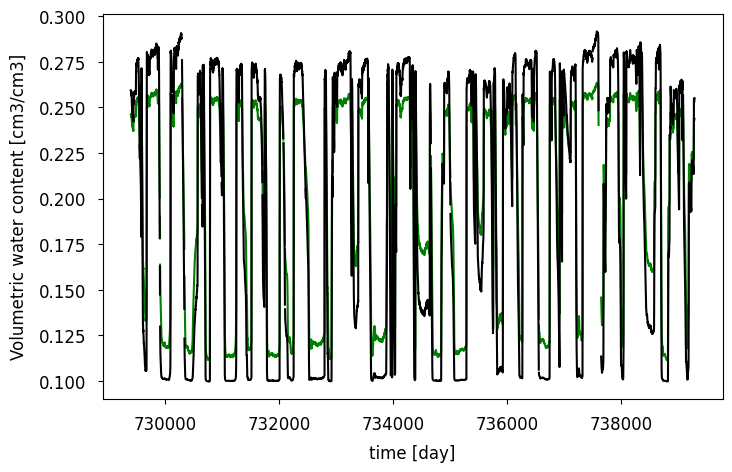

In [ ]:
# Volumetric water content using Rosetta_V3 for Illston et al. (2008) and Zhang et al. (2019) MP equations

fig = plt.figure(figsize=(8,5))
plt.xlabel('time [day]', fontsize=12, labelpad=8)
plt.ylabel('Volumetric water content [cm3/cm3]', fontsize=12, labelpad=8)
plt.tick_params(axis='both', which='major', labelsize=12,pad=8)
plt.tick_params(axis='both', which='minor', labelsize=12, pad=8)

plt.plot(time, vwc3_Ill, color='green', markersize=0.05)
plt.plot(time, vwc3_Zha, color='black', markersize=0.05)